In [1]:
import dataset3

In [2]:
data3 = dataset3.load_data(1)

In [3]:
import rec3
reload (rec3)

<module 'rec3' from 'rec3.pyc'>

ae

In [4]:
import torch
import torch.nn as nn
import os
import numpy as np

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd



In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.representations = dict()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.encoder(x)
        self.representations['hidden'] = out.data.numpy().copy()
        out = self.relu(out)
        self.representations['hidden_relu'] = out.data.numpy().copy()
        out = self.decoder(out)
        self.representations['decode'] = out.data.numpy().copy()
        return out

In [7]:
def rec_pred(pred_ratings):
    pred = rec3.Rec()
    pred.set_prediction_matrix(data3.train_dataset.known, pred_ratings)
    pred.produce_rec_list(data3.train_dataset.known,targets=data3.test_dataset.targets)
    pred.evaluate(test= data3.test_dataset.test, rec_len=5)
    return pred

In [8]:
tmp = np.random.random(data3.train_dataset.train.shape)
rec_pred(pred_ratings=tmp).precision_

0.020529801324503313

In [9]:
who

DataLoader	 Dataset	 Net	 Variable	 data3	 dataset3	 nn	 np	 os	 
pd	 plt	 rec3	 rec_pred	 tmp	 torch	 


training example with input

In [10]:
input_size = 6040
hidden_size = 350
output_size = 6040
loss_history = list()
learning_rate = 0.001



num_epochs = 10

cv = 1



Net (
  (encoder): Linear (6040 -> 350)
  (relu): ReLU ()
  (decoder): Linear (350 -> 6040)
)
Epoch [1/40], Step [1/39], Loss: 0.0379
Epoch [1/40], Step [2/39], Loss: 0.0427
Epoch [1/40], Step [3/39], Loss: 0.0380
Epoch [1/40], Step [4/39], Loss: 0.0357
Epoch [1/40], Step [5/39], Loss: 0.0433
Epoch [1/40], Step [6/39], Loss: 0.0444
Epoch [1/40], Step [7/39], Loss: 0.0370
Epoch [1/40], Step [8/39], Loss: 0.0462
Epoch [1/40], Step [9/39], Loss: 0.0395
Epoch [1/40], Step [10/39], Loss: 0.0298
Epoch [1/40], Step [11/39], Loss: 0.0265
Epoch [1/40], Step [12/39], Loss: 0.0309
Epoch [1/40], Step [13/39], Loss: 0.0353
Epoch [1/40], Step [14/39], Loss: 0.0347
Epoch [1/40], Step [15/39], Loss: 0.0366
Epoch [1/40], Step [16/39], Loss: 0.0309
Epoch [1/40], Step [17/39], Loss: 0.0323
Epoch [1/40], Step [18/39], Loss: 0.0357
Epoch [1/40], Step [19/39], Loss: 0.0277
Epoch [1/40], Step [20/39], Loss: 0.0310
Epoch [1/40], Step [21/39], Loss: 0.0318
Epoch [1/40], Step [22/39], Loss: 0.0300
Epoch [1/40],

KeyboardInterrupt: 

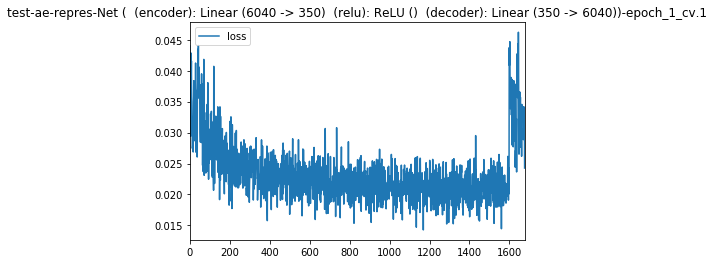

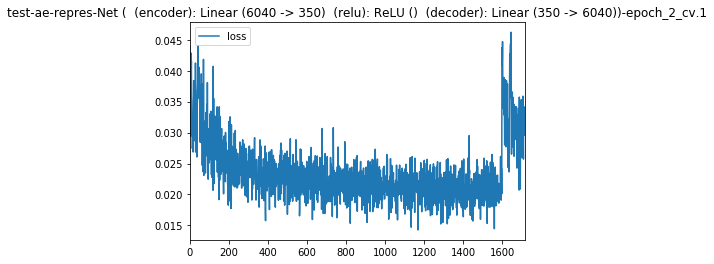

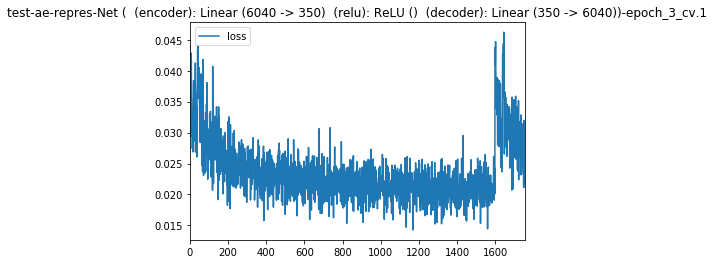

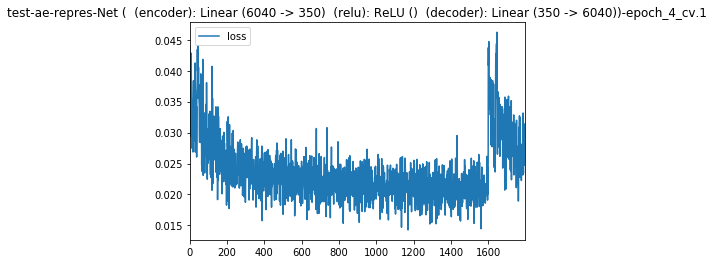

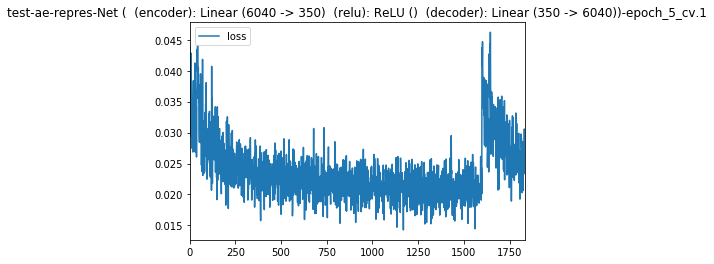

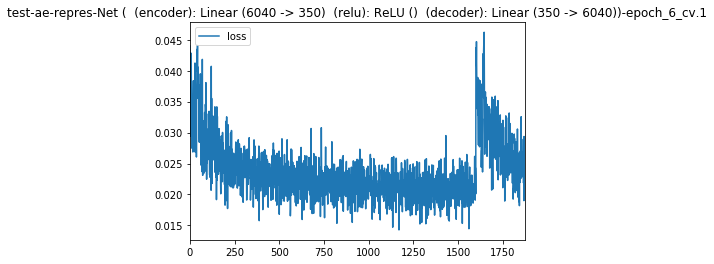

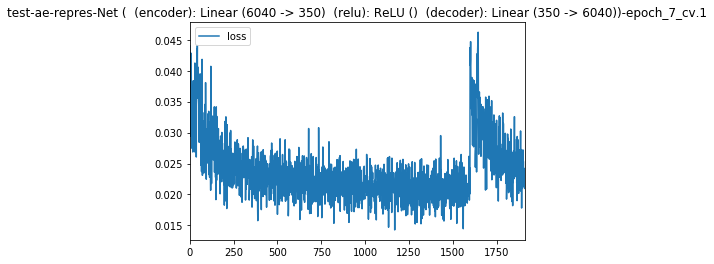

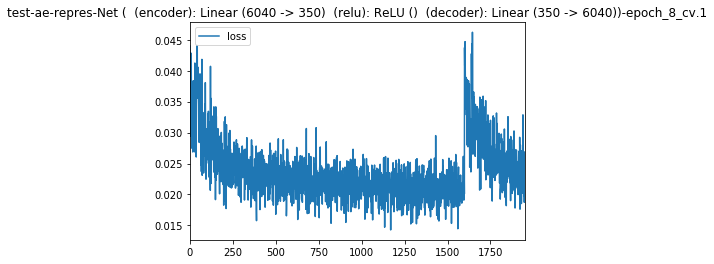

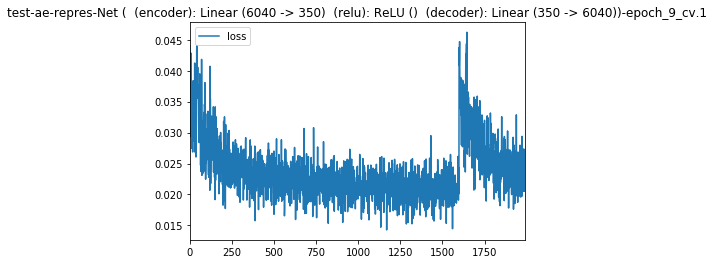

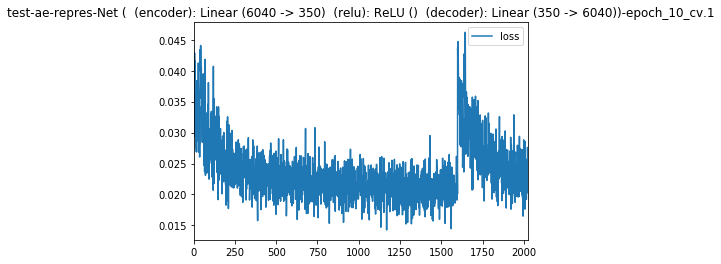

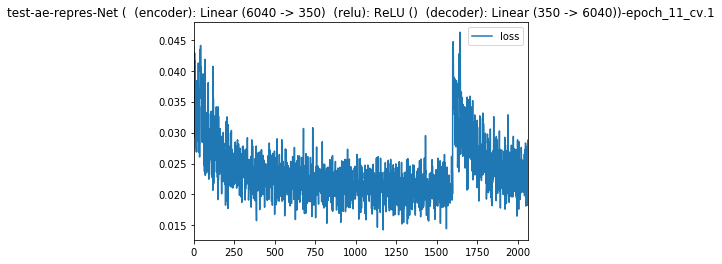

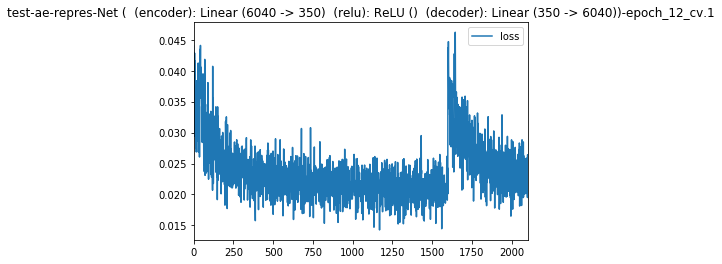

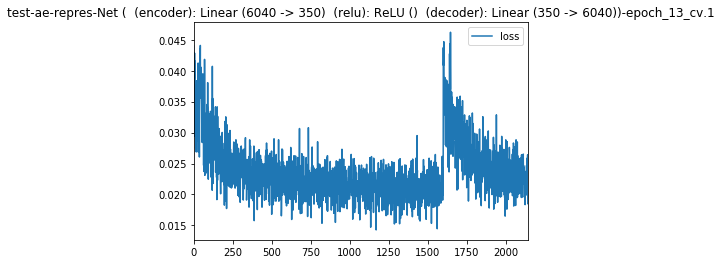

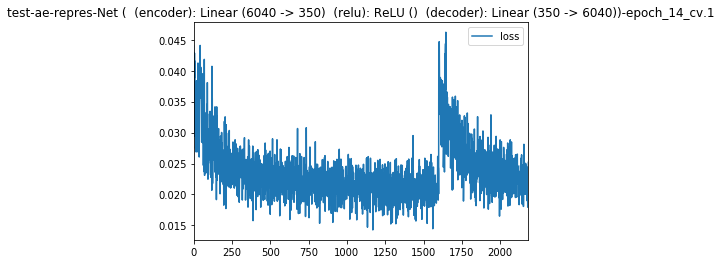

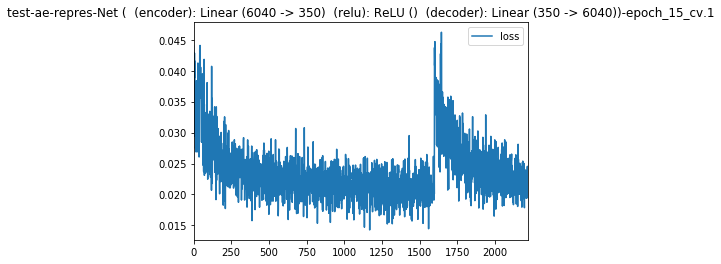

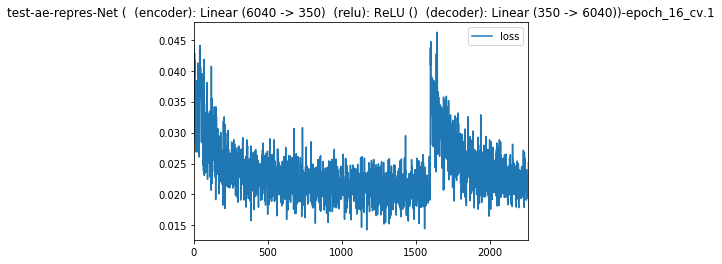

In [15]:
representations = dict()
pred_perf = dict()
cf_perf = dict()


net = Net(input_size, hidden_size, output_size)

certeria = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
print(net.train())
for epoch in range(num_epochs):
    for i_batch, sample_batched in enumerate(data3.train_loader):
#         print(i_batch,sample_batched)
        sample = Variable(sample_batched['sample'])
#         print(sample)
#         sample = Variable()
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(sample)
        loss = certeria(outputs, sample)
#         print(i_batch, loss.data[0])
        loss.backward()
        optimizer.step()
        
        print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   % (epoch + 1, num_epochs, i_batch + 1, 
                      len(data3.train_loader) ,loss.data[0]))
        loss_history.append(loss.data[0])
    iters = epoch +1
    if (iters) % 1 == 0:
#         model = copy.deepcopy(net)
        name = 'test-ae-repres-%s-epoch_%s_cv.%s'%(str(net).replace('\n',''), epoch+1, cv)
        torch.save(net.state_dict(), name)
        representations[iters] = dict()
        print('recommendataion on prediction... Epoch %s'%(iters))
        loss_df= pd.DataFrame(loss_history,columns=['loss'])
        loss_df.plot(title=name)
        predicted = np.zeros_like(data3.train_dataset.train)
        for key in net.representations.keys():
            representations[iters][key] = np.zeros((data3.train_dataset.train.shape[1]
                                                           ,net.representations[key].shape[1]))
#             print(key,(data3.train_dataset.train.shape[1]
#                                                            ,net.representations[key].shape[1]))
#         print('-'*60)
        for item_id in xrange(data3.train_dataset.train.shape[1]):
            sample = Variable(torch.from_numpy(data3.train_dataset.known[:,item_id]))
            output = net(sample)
            for key in net.representations.keys():
                r = representations[iters][key]
#                 print(key, net.representations[key].shape)
                r[item_id, :] = net.representations[key]

            predicted[ :,item_id] = output.data.numpy()
        rec_p = rec_pred(predicted)
        pred_perf[iters] = (rec_p.precision_, rec_p.recall_)
#         pred_perf[iters] = pred_recommend(train=data.train_dataset.train , test=data.test_dataset.test, predicted= predicted)
#         rec on hiddens
        cf_perf[iters] = dict()
        for key in net.representations.keys():
            cf_perf[iters][key]=dict()
            hidden_layer = representations[iters][key]
            cf = rec3.IBCF(sim='cosine')
            cf.fit(train_ratings = data3.train_dataset.train, profile=hidden_layer)
#             cf.compute_score(input_ratings = data3.train_dataset.known, topN=topN, targets=data3.test_dataset.targets)
#             cf.produce_reclist(targets=data3.test_dataset.targets)
#             cf.evaluate(test= data3.test_dataset.test, rec_len=5)
            for knn in [5,50,100,500]:
                print('recommendataion on cf_hidden... Epoch %s, layper %s,topN %s'%(iters, key, knn))
                cf.compute_score(input_ratings = data3.train_dataset.known, topN=knn, targets=data3.test_dataset.targets)
                cf.produce_reclist(targets=data3.test_dataset.targets)
                tmp_perf = cf.evaluate(test= data3.test_dataset.test, rec_len=5)

                cf_perf[iters][key][knn] = tmp_perf


In [16]:
pred_perf

{1: (0.25860927152317886, 0.019600065756604831),
 2: (0.3400662251655629, 0.028067436244854121),
 3: (0.39536423841059604, 0.034252982538119543),
 4: (0.41887417218543044, 0.039462461400229742),
 5: (0.44370860927152317, 0.04409898091677604),
 6: (0.42350993377483448, 0.04416633697732799),
 7: (0.38079470198675497, 0.041622005105545298),
 8: (0.34105960264900664, 0.04030941575635888),
 9: (0.33907284768211921, 0.039413454197931401),
 10: (0.28509933774834434, 0.035248716076842303),
 11: (0.2814569536423841, 0.036334794037817787),
 12: (0.29271523178807951, 0.036924320002561122),
 13: (0.25198675496688738, 0.032402773824312857),
 14: (0.25331125827814571, 0.034524831626637942),
 15: (0.22947019867549667, 0.03251918534048534),
 16: (0.24503311258278146, 0.034633158322575013)}

In [17]:
cf_perf

{1: {'decode': {5: (0.26125827814569541, 0.026251128801033689),
   50: (0.30662251655629141, 0.028796765523351527),
   100: (0.32715231788079469, 0.030404715838140597),
   500: (0.32814569536423843, 0.029829619947113986)},
  'hidden': {5: (0.28675496688741725, 0.032307408539854594),
   50: (0.30662251655629136, 0.032981306421397349),
   100: (0.31092715231788082, 0.031996197021123385),
   500: (0.2675496688741722, 0.027289888590450131)},
  'hidden_relu': {5: (0.26092715231788077, 0.026499353788020534),
   50: (0.30198675496688743, 0.028848044337519578),
   100: (0.3347682119205298, 0.031478461854520953),
   500: (0.32781456953642391, 0.029789120822233509)}},
 2: {'decode': {5: (0.33211920529801325, 0.033027007011289675),
   50: (0.34900662251655629, 0.035995096564394459),
   100: (0.36158940397350997, 0.03360937749655403),
   500: (0.34834437086092718, 0.030171164949154766)},
  'hidden': {5: (0.35033112582781462, 0.038609028866158655),
   50: (0.34867549668874176, 0.036983645872857414)

In [18]:
cf_perf_list = []
for iteration in cf_perf.keys():
    d1 = cf_perf[iteration]
    for hidden in d1.keys():
        d2 = d1[hidden]
        for knn in d2.keys():
            v3 = d2[knn]
            cf_perf_list.append((iteration, hidden, knn,v3[0], v3[1]))

In [19]:
cf_perf_df = pd.DataFrame(cf_perf_list, columns=['iteration','hidden','knn','precision','recall'])

In [20]:
cf_perf_df = cf_perf_df.sort_values(by=['iteration','hidden','knn'])

In [22]:
cf_perf_df[cf_perf_df.groupby('iteration')['precision'].transform(max) == cf_perf_df['precision']]

,iteration,hidden,knn,precision,recall
10,1,hidden_relu,100,0.334768,0.031478
22,2,hidden_relu,100,0.374834,0.037614
26,3,decode,100,0.412252,0.040047
38,4,decode,100,0.425166,0.040981
50,5,decode,100,0.433444,0.043173
62,6,decode,100,0.435430,0.044296
72,7,decode,500,0.415563,0.042822
84,8,decode,500,0.402318,0.040902
98,9,decode,100,0.394371,0.043372
118,10,hidden_relu,100,0.375497,0.041240


In [ ]:
representations

In [25]:
import rec 
reload(rec)
r = rec.Rec()
r.fit(data3.train_dataset.train.T)
t = predicted.T
r.predict( t,data.test_dataset.targets)

AttributeError: Rec instance has no attribute 'fit'

run hidden with larger neighborhood

In [ ]:
import copy

In [ ]:
cf_perf2 = copy.deepcopy(cf_perf)

In [ ]:
import json

In [ ]:
f = open('./ae_iter_no_sigmoid/cf_perf.json','w')
json.dump(cf_perf, f)